In [3]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
seed = 42

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

Uso los dataframe de train y test que salen de data prepocesing.

In [6]:
train = import_data("../datasets/featureEngineering-train.csv")
test = import_data("../datasets/featureEngineering-test.csv")

Memory usage of dataframe is 6.91 MB
Memory usage after optimization is: 1.13 MB
Decreased by 83.7%
Memory usage of dataframe is 1.09 MB
Memory usage after optimization is: 0.17 MB
Decreased by 84.1%


In [30]:
import re
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [18]:
print(train.columns)


Index(['Pricing, Delivery_Terms_Quote_Appr',
       'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval',
       'Bureaucratic_Code_0_Approved', 'Opportunity_ID', 'Sales_Contract_No',
       'USD_factor', 'Total_Amount_USD', 'Total_Taxable_Amount_USD',
       'Family_group_mean', 'Product_group_mean', 'Items', 'Total_Amount_mean',
       'ASP_(converted)_mean', 'TRF_min', 'TRF_max', 'Planned_min_range',
       'Planned_max_range', 'Territory_TRF_mean', 'Territory_TRF_count',
       'Territory_TRF_max', 'QuoteExpiry-OppCreated', 'OppCreated-AccCreated',
       'OppCreated-LastMod', 'PlanStart-OppCreated', 'target',
       'Account_Name_0', 'Account_Name_1', 'Account_Name_2', 'Account_Name_3',
       'Account_Name_4', 'Account_Name_5', 'Account_Name_6', 'Account_Name_7',
       'Account_Name_8', 'Account_Name_9', 'Account_Name_10',
       'Account_Owner_0', 'Account_Owner_1', 'Account_Owner_2',
       'Account_Owner_3', 'Account_Owner_4', 'Account_Owner_5',
       'Delivery

In [47]:
train.drop(columns="Sales_Contract_No",inplace=True)

In [48]:
test.drop(columns="Sales_Contract_No",inplace=True)

In [49]:
def cat_to_dummy(train, test):
    train_d = pd.get_dummies(train, drop_first=False)
    test_d = pd.get_dummies(test, drop_first=False)
    # make sure that the number of features in train and test should be same
    for i in train_d.columns:
        if i not in test_d.columns:
            if i!='TARGET':
                train_d = train_d.drop(i, axis=1)
    for j in test_d.columns:
        if j not in train_d.columns:
            if j!='TARGET':
                test_d = test_d.drop(i, axis=1)
    print('Memory usage of train increases from {:.2f} to {:.2f} MB'.format(train.memory_usage().sum() / 1024**2, 
                                                                            train_d.memory_usage().sum() / 1024**2))
    print('Memory usage of test increases from {:.2f} to {:.2f} MB'.format(test.memory_usage().sum() / 1024**2, 
                                                                            test_d.memory_usage().sum() / 1024**2))
    return train_d, test_d

application_train_ohe, application_test_ohe = cat_to_dummy(train, test)

Memory usage of train increases from 1.11 to 1.10 MB
Memory usage of test increases from 0.17 to 0.17 MB


In [50]:
def cat_to_int(train, test):
    mem_orig_train = train.memory_usage().sum() / 1024**2
    mem_orig_test  = test .memory_usage().sum() / 1024**2
    categorical_feats = [ f for f in train.columns if train[f].dtype == 'object' or train[f].dtype.name == 'category' ]
    print('---------------------')
    print(categorical_feats)
    for f_ in categorical_feats:
        train[f_], indexer = pd.factorize(train[f_])
        test[f_] = indexer.get_indexer(test[f_])
    print('Memory usage of train increases from {:.2f} to {:.2f} MB'.format(mem_orig_train, 
                                                                            train.memory_usage().sum() / 1024**2))
    print('Memory usage of test increases from {:.2f} to {:.2f} MB'.format(mem_orig_test, 
                                                                            test.memory_usage().sum() / 1024**2))
    return categorical_feats, train, test

In [51]:
print(application_train_ohe.columns)

Index(['PricingDelivery_Terms_Quote_Appr', 'PricingDelivery_Terms_Approved',
       'Bureaucratic_Code_0_Approval', 'Bureaucratic_Code_0_Approved',
       'Opportunity_ID', 'USD_factor', 'Total_Amount_USD',
       'Total_Taxable_Amount_USD', 'Family_group_mean', 'Product_group_mean',
       'Items', 'Total_Amount_mean', 'ASP_converted_mean', 'TRF_min',
       'TRF_max', 'Planned_min_range', 'Planned_max_range',
       'Territory_TRF_mean', 'Territory_TRF_count', 'Territory_TRF_max',
       'QuoteExpiryOppCreated', 'OppCreatedAccCreated', 'OppCreatedLastMod',
       'PlanStartOppCreated', 'Account_Name_0', 'Account_Name_1',
       'Account_Name_2', 'Account_Name_3', 'Account_Name_4', 'Account_Name_5',
       'Account_Name_6', 'Account_Name_7', 'Account_Name_8', 'Account_Name_9',
       'Account_Name_10', 'Account_Owner_0', 'Account_Owner_1',
       'Account_Owner_2', 'Account_Owner_3', 'Account_Owner_4',
       'Account_Owner_5', 'Delivery_Terms_0', 'Delivery_Terms_1',
       'Delivery_

In [52]:
X_rus, y_rus = (train.drop(['Opportunity_ID', 'target'], axis=1),
                train['target'])

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.20, random_state=314, stratify=y_rus)

In [54]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [55]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [56]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [57]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
n_HP_points_to_test = 100
#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [58]:
param_grid = {
    'num_leaves': [55, 60, 65],
    'max_depth': [8,10,12],
    'min_gain_to_split':[0.1, 0.2], 
    'max_bin':[50, 100, 150],
    'min_data_in_leaf':[3000, 5000, 7000],
    'bagging_freq':[4,5,6],
    'bagging_fraction':[0.65, 0.7, 0.75],
    'feature_fraction':[0.7]
}

In [59]:
opt_parameters = {'colsample_bytree': 0.9234, 'min_child_samples': 399, 'min_child_weight': 0.1, 'num_leaves': 13, 'reg_alpha': 2, 'reg_lambda': 5, 'subsample': 0.855}

In [60]:
clf_sw = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_sw.set_params(**opt_parameters)

LGBMClassifier(colsample_bytree=0.9234, metric='None', min_child_samples=399,
               min_child_weight=0.1, n_estimators=5000, n_jobs=4, num_leaves=13,
               random_state=314, reg_alpha=2, reg_lambda=5, subsample=0.855)

In [61]:
gs_sample_weight = GridSearchCV(estimator=clf_sw, 
                                param_grid={'scale_pos_weight':[1,2,6,12]},
                                scoring='roc_auc',
                                cv=5,
                                refit=True,
                                verbose=True)

In [64]:
gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training until validation scores don't improve for 30 rounds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[100]	valid's auc: 0.909541
[200]	valid's auc: 0.915969
[300]	valid's auc: 0.919392
[400]	valid's auc: 0.920978
[500]	valid's auc: 0.921671
Early stopping, best iteration is:
[517]	valid's auc: 0.921944
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.907758
[200]	valid's auc: 0.915492
[300]	valid's auc: 0.916437
Early stopping, best iteration is:
[290]	valid's auc: 0.916688
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.910104
[200]	valid's auc: 0.917148
[300]	valid's auc: 0.919972
Early stopping, best iteration is:
[301]	valid's auc: 0.92
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.907692
[200]	valid's auc: 0.913634
[300]	valid's auc: 0.916487
[400]	valid's auc: 0.918317
Early stopping, best iteration is:
[436]	valid's auc: 0.918489
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.910313
[200]	valid's auc: 0.916112
[300]	valid's auc: 0.918924
[400

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   19.4s finished


Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.910583
[200]	valid's auc: 0.918532
[300]	valid's auc: 0.92225
[400]	valid's auc: 0.924373
[500]	valid's auc: 0.925468
Early stopping, best iteration is:
[494]	valid's auc: 0.925549
Best score reached: 0.9288270473698843 with params: {'scale_pos_weight': 6} 


In [65]:
print("Valid+-Std     Train  :   Parameters")
for i in np.argsort(gs_sample_weight.cv_results_['mean_test_score'])[-5:]:
    print('{1:.3f}+-{3:.3f}     {2:.3f}   :  {0}'.format(gs_sample_weight.cv_results_['params'][i], 
                                    gs_sample_weight.cv_results_['mean_test_score'][i], 
                                    gs_sample_weight.cv_results_['mean_train_score'][i],
                                    gs_sample_weight.cv_results_['std_test_score'][i]))

Valid+-Std     Train  :   Parameters


KeyError: 'mean_train_score'

In [66]:
#Configure from the HP optimisation
#clf_final = lgb.LGBMClassifier(**gs.best_estimator_.get_params())

#Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_final.set_params(**opt_parameters)

#Train the final model with learning rate decay
clf_final.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.910664
[200]	valid's auc: 0.916661
[300]	valid's auc: 0.919334
[400]	valid's auc: 0.920541
[500]	valid's auc: 0.921152
[600]	valid's auc: 0.921458
[700]	valid's auc: 0.921622
[800]	valid's auc: 0.921724
[900]	valid's auc: 0.921782
Early stopping, best iteration is:
[884]	valid's auc: 0.9218


LGBMClassifier(colsample_bytree=0.9234, metric='None', min_child_samples=399,
               min_child_weight=0.1, n_estimators=5000, n_jobs=4, num_leaves=13,
               random_state=314, reg_alpha=2, reg_lambda=5, subsample=0.855)

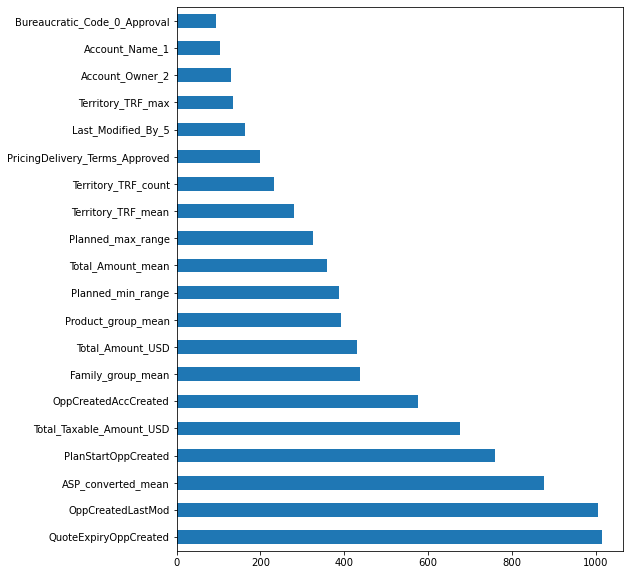

In [67]:
feat_imp = pd.Series(clf_final.feature_importances_, index=train.drop(['Opportunity_ID', 'target'], axis=1).columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(8,10))

In [73]:
probabilities = clf_final.predict_proba(test.drop(['Opportunity_ID'], axis=1))
submission = pd.DataFrame({
    'Opportunity_ID': test['Opportunity_ID'],
    'Target':     [ row[1] for row in probabilities]
})
submission[["Opportunity_ID","Target"]].to_csv("../submits/lgm-optimizacionhiper.csv",index=False)
#submission.to_csv("submission.csv", index=False)
submission[["Opportunity_ID","Target"]]

,Opportunity_ID,Target
0,10689,0.738531
1,10690,0.292652
2,10691,0.562243
3,10692,0.268020
4,10693,0.956054
...,...,...
1562,12364,0.984564
1563,12365,0.194555
1564,12366,0.109087
1565,12367,0.421152


In [69]:
y_true = pd.read_csv("../datasets/Y_TRUE.csv")
A = y_true["Target"]
A

0       0.994320
1       0.990209
2       0.669885
3       0.829021
4       0.998438
          ...   
1562    0.997522
1563    0.932449
1564    0.914969
1565    0.978395
1566    0.852016
Name: Target, Length: 1567, dtype: float64

In [70]:
B = submission["Target"].astype('float').values
B

array([0.73853091, 0.29265245, 0.5622429 , ..., 0.10908749, 0.42115171,
       0.12828045])

In [71]:
from sklearn.metrics import log_loss
log_loss(round(A),B)

0.9853161770801437